Linear Regression R2: 0.6327376121970298
RMSE: 4306.354481692723
                       Coefficient
Temperature             401.771488
Humidity                  4.208669
Wind Speed               50.945277
general diffuse flows    -0.220224
diffuse flows            -3.992633
Hour                    697.897919
Day                      -7.865016
Month                   -85.800448


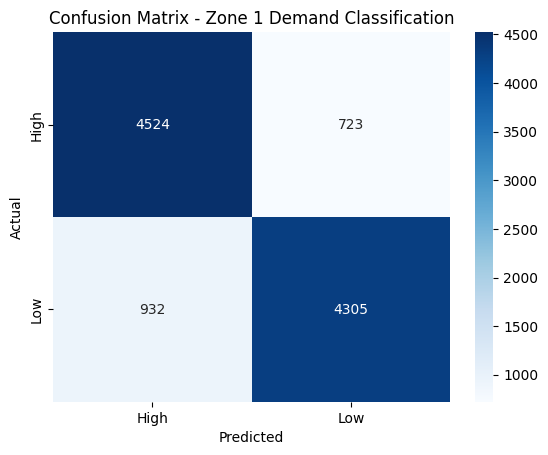

              precision    recall  f1-score   support

        High       0.83      0.86      0.85      5247
         Low       0.86      0.82      0.84      5237

    accuracy                           0.84     10484
   macro avg       0.84      0.84      0.84     10484
weighted avg       0.84      0.84      0.84     10484



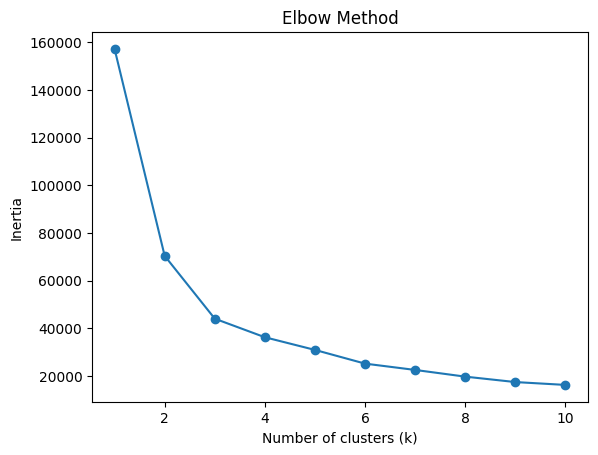

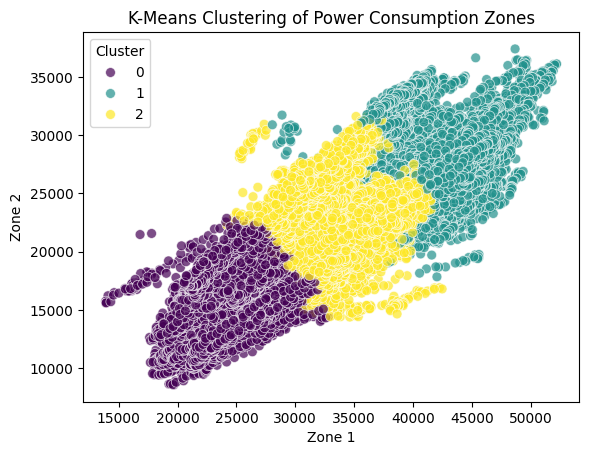

In [6]:
# Install dependencies (if not already installed in Colab)
!pip install xgboost seaborn scikit-learn

# ---------------------------
# 1. Load Libraries
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import xgboost as xgb

# ---------------------------
# 2. Load Dataset
# ---------------------------
df = pd.read_csv("/content/power consumption.csv")

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Convert DateTime to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed', dayfirst=True)

# Extract time features
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month

# Features and Targets
X = df[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Hour','Day','Month']]
y = df[['Zone 1','Zone 2','Zone 3']]

# ---------------------------
# 3. Regression (Prediction)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y['Zone 1'], test_size=0.2, random_state=42)

# Example: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature Importance (coefficients)
coefficients = pd.DataFrame(lr.coef_.T, index=X.columns, columns=['Coefficient'])
print(coefficients)

# ---------------------------
# 4. Classification (High / Low demand)
# ---------------------------
# Make classification target from Zone 1
df['Zone1_Class'] = pd.qcut(df['Zone 1'], q=2, labels=["Low","High"])  # Binary classes

X_cls = X
y_cls = df['Zone1_Class']

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred_cls = clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_cls)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Zone 1 Demand Classification")
plt.show()

print(classification_report(y_test, y_pred_cls))

# ---------------------------
# 5. Clustering (KMeans)
# ---------------------------
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Zone 1','Zone 2','Zone 3']])

inertia = []
k_range = range(1,11)
for k in k_range:
    kmean = KMeans(n_clusters=k, random_state=42)
    kmean.fit(data_scaled)
    inertia.append(kmean.inertia_)

# Elbow Method
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Choose k=3 for example
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(data_scaled)

sns.scatterplot(x="Zone 1", y="Zone 2", hue="Cluster", data=df, palette="viridis", s=50, alpha=0.7)
plt.title("K-Means Clustering of Power Consumption Zones")
plt.xlabel("Zone 1")
plt.ylabel("Zone 2")
plt.show()